In [10]:
import os
import sys
import pickle as pk
import numpy as np

project_root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "src", "model"))
sys.path.append(os.path.join(project_root, "src", "rules"))
sys.path.append(os.path.join(project_root, "src", "fuzzy"))

from src.model import evaluate_model as em
from src.model import train_model as mod
from src.rules import extract_crisp_rules as cr
from src.fuzzy import fuzzy_inference as fi
from src.fuzzy import export_fuzzy_objects as ef

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, 
    f1_score, confusion_matrix
)
import pandas as pd

In [11]:
from config import LOAN_FILE,MODEL_DIR, PKL_DIR
    
pklList=mod.read_all_pkl_files(PKL_DIR)
pklList

{'X_test.pkl':          last_fico_range_high  recoveries  term_num  fico_range_low  \
 1593248                 649.0         0.0        36           735.0   
 1548776                 649.0         0.0        60           670.0   
 2278832                 719.0         0.0        60           730.0   
 2327643                 719.0         0.0        36           695.0   
 2676968                 769.0         0.0        36           695.0   
 ...                       ...         ...       ...             ...   
 2173988                 779.0         0.0        60           780.0   
 1951656                 599.0         0.0        36           670.0   
 860745                  679.0         0.0        60           680.0   
 2527918                 704.0         0.0        36           695.0   
 1563390                 599.0         0.0        36           675.0   
 
          total_rec_late_fee  acc_open_past_24mths    dti  mort_acc  loan_amnt  \
 1593248                 0.0          

In [12]:

print("[INFO] Model loaded:")
catboost_model, catboost_metrics, X_train_encoded, cat_mappings = mod.load_model(os.path.join(MODEL_DIR, 'catboost_NEW_encoded_20260209_192057_model.cbm'))

print(f"  Model type: {catboost_metrics.get('model_type')}")
print(f"  Saved date: {catboost_metrics.get('saved_date')}")
print(f"  Optimal threshold: {catboost_metrics.get('optimal_threshold')}")

[INFO] Model loaded:
[INFO] CatBoost model loaded from: c:\data\phd\codigo python\fuzzy research\fuzzy xai\01 fuzzy inference system\object\model\catboost_NEW_encoded_20260209_192057_model.cbm
[INFO] Metrics loaded from: c:\data\phd\codigo python\fuzzy research\fuzzy xai\01 fuzzy inference system\object\model\catboost_NEW_encoded_20260209_192057_metrics.json
[INFO] Category mappings loaded from: c:\data\phd\codigo python\fuzzy research\fuzzy xai\01 fuzzy inference system\object\model\catboost_NEW_encoded_20260209_192057_category_mappings.pkl
  Encoded features: ['debt_settlement_flag', 'grade', 'verification_status']
[INFO] X_train_encoded loaded from: c:\data\phd\codigo python\fuzzy research\fuzzy xai\01 fuzzy inference system\object\model\catboost_NEW_encoded_20260209_192057_X_train_encoded.parquet
  Shape: (1304459, 12)
  Model type: CatBoost
  Saved date: 2026-02-09 19:20:58
  Optimal threshold: 0.43000000000000005


In [13]:
X_train = pklList['X_train.pkl']
y_train = pklList['y_train.pkl']
X_test=pklList['X_test.pkl']
y_test=pklList['y_test.pkl']

In [14]:
print("Catboost feature names:")
print(catboost_model.feature_names_)

Catboost feature names:
['last_fico_range_high', 'recoveries', 'term_num', 'fico_range_low', 'total_rec_late_fee', 'acc_open_past_24mths', 'dti', 'mort_acc', 'loan_amnt', 'debt_settlement_flag', 'grade', 'verification_status']


In [15]:
y_test.unique
y_test.value_counts()/len(y_test)

bad_good
0    0.805328
1    0.194672
Name: count, dtype: float64

In [16]:
y_train.unique
y_train.value_counts()/len(y_train)

bad_good
0    0.804586
1    0.195414
Name: count, dtype: float64

In [17]:
all_features = X_train.columns.tolist()
(all_features)

['last_fico_range_high',
 'recoveries',
 'term_num',
 'fico_range_low',
 'total_rec_late_fee',
 'acc_open_past_24mths',
 'dti',
 'mort_acc',
 'loan_amnt',
 'debt_settlement_flag',
 'grade',
 'verification_status']

In [18]:
# Compute CatBoost feature importances and list top features by importance
feature_importances = catboost_model.get_feature_importance() * 100
print(f"Feature importances length: {len(feature_importances)}")

top_features_idx = np.argsort(feature_importances)[-60:]
print(f"Top feature indices identified: {top_features_idx}")

top_features = [all_features[i] for i in top_features_idx if i < len(all_features)]
print(f"Top features identified: {top_features}")


Feature importances length: 12
Top feature indices identified: [11  4  7 10  5  6  3  8  9  2  0  1]
Top features identified: ['verification_status', 'total_rec_late_fee', 'mort_acc', 'grade', 'acc_open_past_24mths', 'dti', 'fico_range_low', 'loan_amnt', 'debt_settlement_flag', 'term_num', 'last_fico_range_high', 'recoveries']


In [19]:
# select balanced trees from the CatBoost model using the training data
balanced_trees = cr.get_catboost_trees(
    catboost_model,
    X_train_encoded,
    y_train,
    n_trees=None,
    max_samples=3000000,  # Extract all samples, without limitation.
    parallel_jobs=-1 #run in parallel using all available CPU cores
)
print(f"[INFO] Balanced trees selected: {len(balanced_trees)}")


[INFO] -------------------- Tree Selection Process --------------------
[INFO] Using ALL 68 trees (no selection needed)

[INFO] -------------------- Selection Complete --------------------
[INFO] Balanced trees selected: 68


In [20]:
# Extract crisp rules from the selected balanced trees using the training data
cb_rules = cr.extract_rules_from_trees(
    catboost_model, X_train_encoded, y_train,
    min_confidence=0,
    min_support=0,
    tree_index_list=balanced_trees,
    parallel_jobs=-1
)


[INFO] -------------------- CatBoost Rule Extraction --------------------

[INFO] Dataset statistics:
  Total samples: 1,304,459
  Class 0: 1,049,549 (80.5%)
  Class 1: 254,910 (19.5%)

[INFO] Creating CatBoost Pool...
   All features treated as numeric (pre-encoded)

[INFO] Processing 68 trees...

   [INFO] Extracted 1,681 rules
   [INFO] All conditions are numeric (categorical features encoded)

   [INFO] Metrics validation:
     Class 0: 571 rules
       - Avg Precision: 0.732
       - High quality (>0.7): 344 (60.2%)
     Class 1: 1,110 rules
       - Avg Precision: 0.682
       - High quality (>0.7): 656 (59.1%)

   [INFO] Quality distribution:
     Min precision:    0.006
     25th percentile:  0.417
     Median:           0.915
     75th percentile:  1.000
     Max precision:    1.000

[INFO] -------------------- Extraction Complete --------------------


In [21]:
unique_rules = cr.remove_duplicate_rules(cb_rules)
unique_rules


[INFO] Processing rule with conditions: ('last_fico_range_high <= 581.500000', 'last_fico_range_high <= 631.500000', 'recoveries <= 0.005000', 'recoveries <= 1730.060059', 'term_num <= 48.000000')

[INFO] Processing rule with conditions: ('last_fico_range_high <= 581.500000', 'last_fico_range_high > 631.500000', 'recoveries <= 0.005000', 'recoveries <= 1730.060059', 'term_num <= 48.000000')

[INFO] Processing rule with conditions: ('last_fico_range_high <= 581.500000', 'last_fico_range_high <= 631.500000', 'recoveries <= 0.005000', 'recoveries > 1730.060059', 'term_num <= 48.000000')

[INFO] Processing rule with conditions: ('last_fico_range_high <= 581.500000', 'last_fico_range_high > 631.500000', 'recoveries <= 0.005000', 'recoveries > 1730.060059', 'term_num <= 48.000000')

[INFO] Processing rule with conditions: ('last_fico_range_high <= 581.500000', 'last_fico_range_high <= 631.500000', 'recoveries <= 0.005000', 'recoveries <= 1730.060059', 'term_num > 48.000000')

[INFO] Process

[{'tree_idx': 0,
  'leaf_idx': 0,
  'rule_conditions': ['recoveries <= 0.005000',
   'last_fico_range_high <= 581.500000',
   'term_num <= 48.000000',
   'recoveries <= 1730.060059',
   'last_fico_range_high <= 631.500000'],
  'logit_score': -0.5791074310451048,
  'predicted_class': 0,
  'confidence': 0.579107,
  'support': 0.055417,
  'precision': 0.6408,
  'purity': 0.6408,
  'quality_score': 0.6408,
  'samples_covered': 72289,
  'class_0_count': 46323,
  'class_1_count': 25966,
  'features_involved': ['last_fico_range_high', 'recoveries', 'term_num'],
  'feature_count': 3,
  'condition_count': 5,
  'tp': 46323,
  'fp': 25966},
 {'tree_idx': 0,
  'leaf_idx': 1,
  'rule_conditions': ['recoveries <= 0.005000',
   'last_fico_range_high <= 581.500000',
   'term_num <= 48.000000',
   'recoveries <= 1730.060059',
   'last_fico_range_high > 631.500000'],
  'logit_score': 10.61425670868059,
  'predicted_class': 1,
  'confidence': 10.614257,
  'support': 0.04363,
  'precision': 1.0,
  'purity

In [22]:

# Analyze the distribution of predicted classes in the extracted rules
total_rules = len(unique_rules)
count_predicted_class_1 = sum(
    1 for rule in unique_rules if rule.get("predicted_class") == 1
)
count_predicted_class_0 = sum(
    1 for rule in unique_rules if rule.get("predicted_class") == 0
)

print(f"\n[INFO] Total rules : {total_rules}")
print(f"[INFO] Rules class 1: {count_predicted_class_1} ({count_predicted_class_1/total_rules:.2%})")
print(f"[INFO] Rules class 0: {count_predicted_class_0} ({count_predicted_class_0/total_rules:.2%})")


[INFO] Total rules : 1681
[INFO] Rules class 1: 1110 (66.03%)
[INFO] Rules class 0: 571 (33.97%)


In [23]:
structured_rules = cr.convert_rules_to_simple_format(unique_rules)
structured_rules

[{'tree_id': 0,
  'conditions': ['recoveries <= 0.005000',
   'last_fico_range_high <= 581.500000',
   'term_num <= 48.000000',
   'recoveries <= 1730.060059',
   'last_fico_range_high <= 631.500000'],
  'predicted_class': 0,
  'logit_score': -0.5791074310451048,
  'confidence': 0.579107,
  'support': 0.055417,
  'precision': 0.6408},
 {'tree_id': 0,
  'conditions': ['recoveries <= 0.005000',
   'last_fico_range_high <= 581.500000',
   'term_num <= 48.000000',
   'recoveries <= 1730.060059',
   'last_fico_range_high > 631.500000'],
  'predicted_class': 1,
  'logit_score': 10.61425670868059,
  'confidence': 10.614257,
  'support': 0.04363,
  'precision': 1.0},
 {'tree_id': 0,
  'conditions': ['recoveries <= 0.005000',
   'last_fico_range_high <= 581.500000',
   'term_num <= 48.000000',
   'recoveries > 1730.060059',
   'last_fico_range_high <= 631.500000'],
  'predicted_class': 0,
  'logit_score': -1.900557595696344,
  'confidence': 1.900558,
  'support': 0.048246,
  'precision': 0.8695

In [24]:

cat_mappings_fixed = {
    var: {code: cat for cat, code in mapping.items()}
    for var, mapping in cat_mappings.items()
}

print("[INFO] CREATING FUZZY SYSTEM (ONE-TIME SETUP)")

#Comparing the performance of different tree-based strategies for rule extraction, use logits as the output type for the fuzzy inference system to capture the confidence of predictions, which can enhance the interpretability and performance of the system.
results = cr.compare_tree_strategies(structured_rules, [5,10, 15, 20, 25, 30, 35, 40, 45 ,50,55,60,65])


[INFO] CREATING FUZZY SYSTEM (ONE-TIME SETUP)

[INFO] -------------------- Comparing Tree Strategies --------------------
[INFO] Total trees available: 68

[INFO] 5 trees:
  Rules: 159 (C0:45, C1:114)
  Sum C0: -12.3
  Sum C1: 11.5
  Net:    -0.8

[INFO] 10 trees:
  Rules: 319 (C0:84, C1:235)
  Sum C0: -17.3
  Sum C1: 20.0
  Net:    +2.7

[INFO] 15 trees:
  Rules: 463 (C0:120, C1:343)
  Sum C0: -29.0
  Sum C1: 77.6
  Net:    +48.6

[INFO] 20 trees:
  Rules: 589 (C0:159, C1:430)
  Sum C0: -49.3
  Sum C1: 113.3
  Net:    +64.1

[INFO] 25 trees:
  Rules: 717 (C0:204, C1:513)
  Sum C0: -65.4
  Sum C1: 124.5
  Net:    +59.1

[INFO] 30 trees:
  Rules: 836 (C0:232, C1:604)
  Sum C0: -70.4
  Sum C1: 138.0
  Net:    +67.6

[INFO] 35 trees:
  Rules: 956 (C0:261, C1:695)
  Sum C0: -76.6
  Sum C1: 144.5
  Net:    +67.9

[INFO] 40 trees:
  Rules: 1068 (C0:284, C1:784)
  Sum C0: -93.2
  Sum C1: 280.2
  Net:    +187.0

[INFO] 45 trees:
  Rules: 1175 (C0:317, C1:858)
  Sum C0: -107.5
  Sum C1: 292.2
 

In [25]:
import time
setup_start = time.time()

X_test_encoded = mod.encode_data_like_training(X_test, cat_mappings)
n_trees = 25

filtered_rules = cr.select_best_trees(structured_rules, n_trees=n_trees)
threshold = catboost_metrics['optimal_threshold']

cutpoints, linguistic_terms, fuzzy_rules, _ = fi.evaluate_fuzzy_system(
    catboost_rules=filtered_rules,
    catboost_predictions=catboost_model.predict(X_test_encoded[:100]),
    X_train=X_train_encoded,
    X_test=X_test_encoded[:100],
    y_test=y_test.values[:100],
    category_mappings=cat_mappings_fixed,
    classification_threshold=0.5,
    t_norm_operator='min',
    evaluation_sample_size=100,
    parallel_jobs=1,
    apply_purpose_grouping=True
)

setup_time = time.time() - setup_start

print(f"\n[INFO] Fuzzy system created in {setup_time:.1f}s:")
print(f"  Variables: {len(linguistic_terms)}")
print(f"  Fuzzy rules: {len(fuzzy_rules):,}")
print(f"  Categorical decoded: {sum(1 for r in fuzzy_rules for a in r['antecedents'] if a.get('is_categorical', False)):,}")


[INFO] -------------------- Selecting 25 Best Trees --------------------

[INFO] Selected 717 rules from 25 trees
  Class 0: 204 rules, sum=-65.4
  Class 1: 513 rules, sum=124.5
  Net sum: +59.1
  Imbalanced
[INFO] ----------------------------------------------------------------

[INFO] -------------------- Fuzzy CatBoost System Evaluation --------------------
Classification threshold: 0.5
T-norm operator: min
Purpose grouping: True
All features treated as numeric (categorical pre-encoded)
[INFO] -------------------------------------------------------------------------

[INFO] Step 1: Extracting variable conditions from rules
[INFO] Rules processed: 717
[INFO] Variables identified: 12

[INFO] Step 2: Optimizing cutpoints with auto-strategy selection
[INFO] last_fico_range_high: numeric -> adaptive, 13 cutpoints, 7 terms
[INFO] recoveries: numeric -> adaptive, 4 cutpoints, 3 terms
[INFO] debt_settlement_flag: categorical [CATEGORICAL] -> density_, 4 cutpoints, 3 terms
[INFO] dti: numer

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [26]:
print("\n[INFO] -------------------- Grid Search: Threshold --------------------")

top_k_values = [n_trees]
threshold_values = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.7, 0.75, 0.80]

best_f1 = 0.0
best_config = None
results_grid = []

sample_size = 50000 #Use a larger sample size for more reliable evaluation, but be mindful of execution time.

sss = StratifiedShuffleSplit(
    n_splits=1, 
    test_size=sample_size, 
    random_state=42
)

y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

sample_idx = next(sss.split(X_test_encoded, y_test_array))[1]

y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

X_test_sample = X_test_encoded.iloc[sample_idx].reset_index(drop=True)
y_test_sample = y_test_array[sample_idx]

print(f"\n[INFO] Test sample: {len(X_test_sample):,} samples")
print(f"[INFO] Configurations to test: {len(top_k_values) * len(threshold_values)}")

for i, (top_k, threshold) in enumerate([(k, t) for k in top_k_values for t in threshold_values]):
    print(f"\n[INFO] ----------------------------------------------------------------")
    print(f"[INFO] Config {i+1}/{len(top_k_values)*len(threshold_values)}: top_k={top_k}, threshold={threshold}")
    print(f"[INFO] ----------------------------------------------------------------")
    
    try:
        config_start = time.time()
        
        fuzzy_predictions = fi.execute_fuzzy_inference(
            X_test_sample,
            fuzzy_rules,
            linguistic_terms,
            cat_mappings_fixed,
            t_norm_operator='min',
            classification_threshold=threshold,
            parallel_jobs=-1
        )
        
        config_time = time.time() - config_start
        
        acc = accuracy_score(y_test_sample, fuzzy_predictions)
        sens = recall_score(y_test_sample, fuzzy_predictions, pos_label=1, zero_division=0)
        prec = precision_score(y_test_sample, fuzzy_predictions, pos_label=1, zero_division=0)
        f1 = f1_score(y_test_sample, fuzzy_predictions, pos_label=1, zero_division=0)
        
        cm = confusion_matrix(y_test_sample, fuzzy_predictions)
        tn, fp, fn, tp = cm.ravel()
        
        results_grid.append({
            'top_k': top_k,
            'threshold': threshold,
            'accuracy': acc,
            'sensitivity': sens,
            'precision': prec,
            'f1_score': f1,
            'time_sec': config_time,
            'tp': int(tp),
            'fp': int(fp),
            'tn': int(tn),
            'fn': int(fn)
        })
        
        if f1 > best_f1:
            best_f1 = f1
            best_config = (top_k, threshold)
            best_predictions = fuzzy_predictions.copy()
        
        print(f"\n[INFO] Completed in {config_time:.1f}s")
        print(f"\n[INFO] Metrics:")
        print(f"    Accuracy:    {acc:.4f}")
        print(f"    Sensitivity: {sens:.4f}")
        print(f"    Precision:   {prec:.4f}")
        print(f"    F1:          {f1:.4f}")
        
        print(f"\n[INFO] Confusion Matrix:")
        print(f"    TP: {tp:,}  FP: {fp:,}")
        print(f"    FN: {fn:,}  TN: {tn:,}")
        
    except Exception as e:
        print(f"\n[ERROR] {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n[INFO] -------------------- Grid Search Results --------------------")

if len(results_grid) > 0:
    print(f"\n{'Top-K':<8} {'Thresh':<8} {'Acc':<8} {'Sens':<8} {'Prec':<8} {'F1':<8} {'Time(s)':<10}")
    print("-" * 70)
    
    for result in sorted(results_grid, key=lambda x: x['f1_score'], reverse=True):
        marker = " <- BEST" if (result['top_k'], result['threshold']) == best_config else ""
        print(f"{result['top_k']:<8} {result['threshold']:<8.2f} "
              f"{result['accuracy']:<8.4f} {result['sensitivity']:<8.4f} "
              f"{result['precision']:<8.4f} {result['f1_score']:<8.4f} "
              f"{result['time_sec']:<10.1f}{marker}")
    
    if best_config:
        print(f"\n[INFO] -------------------- Best Configuration --------------------")
        
        best_result = [r for r in results_grid if (r['top_k'], r['threshold']) == best_config][0]
        
        print(f"\n[INFO] Configuration:")
        print(f"  Top-K trees: {best_config[0]}")
        print(f"  Threshold:   {best_config[1]}")
        
        print(f"\n[INFO] Performance:")
        print(f"  Accuracy:    {best_result['accuracy']:.4f}")
        print(f"  Sensitivity: {best_result['sensitivity']:.4f}")
        print(f"  Precision:   {best_result['precision']:.4f}")
        print(f"  F1-Score:    {best_result['f1_score']:.4f}")
        
        print(f"\n[INFO] Confusion Matrix:")
        print(f"                 Predicted")
        print(f"               Good (0)  Bad (1)")
        print(f"  Actual Good  {best_result['tn']:8,}  {best_result['fp']:8,}")
        print(f"         Bad   {best_result['fn']:8,}  {best_result['tp']:8,}")

else:
    print("\n[ERROR] No results obtained - check for errors")

print("\n[INFO] ----------------------------------------------------------------")


[INFO] -------------------- Grid Search: Threshold --------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Test sample: 50,000 samples
[INFO] Configurations to test: 13

[INFO] ----------------------------------------------------------------
[INFO] Config 1/13: top_k=25, threshold=0.2
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 21.9s
[INFO] Throughput: 2286.9 samples/sec

[INFO] Completed in 21.9s

[INFO] Metrics:
    Accuracy:    0.1947
    Sensitivity: 1.0000
    Precision:   0.1947
    F1:          0.3259

[INFO] Confusion Matrix:
    TP: 9,734  FP: 40,265
    FN: 0  TN: 1

[INFO] ----------------------------------------------------------------
[INFO] Config 2/13: top_k=25, threshold=0.25
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 21.5s
[INFO] Throughput: 2324.6 samples/sec

[INFO] Completed in 21.5s

[INFO] Metrics:
    Accuracy:    0.1947
    Sensitivity: 1.0000
    Precision:   0.1947
    F1:          0.3259

[INFO] Confusion Matrix:
    TP: 9,734  FP: 40,265
    FN: 0  TN: 1

[INFO] ----------------------------------------------------------------
[INFO] Config 3/13: top_k=25, threshold=0.3
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 23.7s
[INFO] Throughput: 2106.9 samples/sec

[INFO] Completed in 23.7s

[INFO] Metrics:
    Accuracy:    0.1947
    Sensitivity: 1.0000
    Precision:   0.1947
    F1:          0.3259

[INFO] Confusion Matrix:
    TP: 9,734  FP: 40,264
    FN: 0  TN: 2

[INFO] ----------------------------------------------------------------
[INFO] Config 4/13: top_k=25, threshold=0.35
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 25.0s
[INFO] Throughput: 2001.1 samples/sec

[INFO] Completed in 25.0s

[INFO] Metrics:
    Accuracy:    0.1948
    Sensitivity: 1.0000
    Precision:   0.1947
    F1:          0.3259

[INFO] Confusion Matrix:
    TP: 9,734  FP: 40,262
    FN: 0  TN: 4

[INFO] ----------------------------------------------------------------
[INFO] Config 5/13: top_k=25, threshold=0.4
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 27.9s
[INFO] Throughput: 1793.2 samples/sec

[INFO] Completed in 27.9s

[INFO] Metrics:
    Accuracy:    0.1948
    Sensitivity: 0.9999
    Precision:   0.1947
    F1:          0.3259

[INFO] Confusion Matrix:
    TP: 9,733  FP: 40,259
    FN: 1  TN: 7

[INFO] ----------------------------------------------------------------
[INFO] Config 6/13: top_k=25, threshold=0.45
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.3s finished



[INFO] Inference completed in 28.5s
[INFO] Throughput: 1752.1 samples/sec

[INFO] Completed in 28.5s

[INFO] Metrics:
    Accuracy:    0.1950
    Sensitivity: 0.9993
    Precision:   0.1947
    F1:          0.3258

[INFO] Confusion Matrix:
    TP: 9,727  FP: 40,243
    FN: 7  TN: 23

[INFO] ----------------------------------------------------------------
[INFO] Config 7/13: top_k=25, threshold=0.5
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 30.1s
[INFO] Throughput: 1661.3 samples/sec

[INFO] Completed in 30.1s

[INFO] Metrics:
    Accuracy:    0.1957
    Sensitivity: 0.9984
    Precision:   0.1947
    F1:          0.3258

[INFO] Confusion Matrix:
    TP: 9,718  FP: 40,198
    FN: 16  TN: 68

[INFO] ----------------------------------------------------------------
[INFO] Config 8/13: top_k=25, threshold=0.55
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 27.9s
[INFO] Throughput: 1790.5 samples/sec

[INFO] Completed in 27.9s

[INFO] Metrics:
    Accuracy:    0.1995
    Sensitivity: 0.9955
    Precision:   0.1951
    F1:          0.3262

[INFO] Confusion Matrix:
    TP: 9,690  FP: 39,980
    FN: 44  TN: 286

[INFO] ----------------------------------------------------------------
[INFO] Config 9/13: top_k=25, threshold=0.6
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 25.3s
[INFO] Throughput: 1975.9 samples/sec

[INFO] Completed in 25.3s

[INFO] Metrics:
    Accuracy:    0.2169
    Sensitivity: 0.9856
    Precision:   0.1974
    F1:          0.3289

[INFO] Confusion Matrix:
    TP: 9,594  FP: 39,016
    FN: 140  TN: 1,250

[INFO] ----------------------------------------------------------------
[INFO] Config 10/13: top_k=25, threshold=0.65
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 24.1s
[INFO] Throughput: 2076.7 samples/sec

[INFO] Completed in 24.1s

[INFO] Metrics:
    Accuracy:    0.2810
    Sensitivity: 0.9584
    Precision:   0.2079
    F1:          0.3417

[INFO] Confusion Matrix:
    TP: 9,329  FP: 35,543
    FN: 405  TN: 4,723

[INFO] ----------------------------------------------------------------
[INFO] Config 11/13: top_k=25, threshold=0.7
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 25.4s
[INFO] Throughput: 1967.6 samples/sec

[INFO] Completed in 25.4s

[INFO] Metrics:
    Accuracy:    0.4338
    Sensitivity: 0.9153
    Precision:   0.2448
    F1:          0.3863

[INFO] Confusion Matrix:
    TP: 8,910  FP: 27,486
    FN: 824  TN: 12,780

[INFO] ----------------------------------------------------------------
[INFO] Config 12/13: top_k=25, threshold=0.75
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



[INFO] Inference completed in 26.3s
[INFO] Throughput: 1900.8 samples/sec

[INFO] Completed in 26.3s

[INFO] Metrics:
    Accuracy:    0.6592
    Sensitivity: 0.8728
    Precision:   0.3496
    F1:          0.4993

[INFO] Confusion Matrix:
    TP: 8,496  FP: 15,803
    FN: 1,238  TN: 24,463

[INFO] ----------------------------------------------------------------
[INFO] Config 13/13: top_k=25, threshold=0.8
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 50,000
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 500
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   22.3s



[INFO] Inference completed in 26.3s
[INFO] Throughput: 1897.6 samples/sec

[INFO] Completed in 26.3s

[INFO] Metrics:
    Accuracy:    0.8037
    Sensitivity: 0.8202
    Precision:   0.4975
    F1:          0.6193

[INFO] Confusion Matrix:
    TP: 7,984  FP: 8,065
    FN: 1,750  TN: 32,201

[INFO] -------------------- Grid Search Results --------------------

Top-K    Thresh   Acc      Sens     Prec     F1       Time(s)   
----------------------------------------------------------------------
25       0.80     0.8037   0.8202   0.4975   0.6193   26.3       <- BEST
25       0.75     0.6592   0.8728   0.3496   0.4993   26.3      
25       0.70     0.4338   0.9153   0.2448   0.3863   25.4      
25       0.65     0.2810   0.9584   0.2079   0.3417   24.1      
25       0.60     0.2169   0.9856   0.1974   0.3289   25.3      
25       0.55     0.1995   0.9955   0.1951   0.3262   27.9      
25       0.35     0.1948   1.0000   0.1947   0.3259   25.0      
25       0.30     0.1947   1.0000   0.

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.1s finished


In [27]:
#Evaluate best configuration on full test set in fuzzy inference system

#The best_k and threshold values to test
top_k_values = [n_trees]
threshold_values = [0.75]


best_f1 = 0.0
best_config = None
results_grid = []

#use all test data for final evaluation
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test


print(f"\nTest: {len(X_test_encoded):,} Total Rows")
print(f"Configurations to test: {len(top_k_values) * len(threshold_values)}")


print("\n[INFO] -------------------- Grid Search: Threshold --------------------")

top_k_values = [n_trees]
threshold_values = [0.75]

best_f1 = 0.0
best_config = None
results_grid = []



y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

print(f"\n[INFO] Test sample: {len(X_test_encoded):,} samples")
print(f"[INFO] Configurations to test: {len(top_k_values) * len(threshold_values)}")

for i, (top_k, threshold) in enumerate([(k, t) for k in top_k_values for t in threshold_values]):
    print(f"\n[INFO] ----------------------------------------------------------------")
    print(f"[INFO] Config {i+1}/{len(top_k_values)*len(threshold_values)}: top_k={top_k}, threshold={threshold}")
    print(f"[INFO] ----------------------------------------------------------------")
    
    try:
        config_start = time.time()
        
        fuzzy_predictions = fi.execute_fuzzy_inference(
            X_test_encoded,
            fuzzy_rules,
            linguistic_terms,
            cat_mappings_fixed,
            t_norm_operator='min',
            classification_threshold=threshold,
            parallel_jobs=-1
        )
        
        config_time = time.time() - config_start
        
        acc = accuracy_score(y_test_array, fuzzy_predictions)
        sens = recall_score(y_test_array, fuzzy_predictions, pos_label=1, zero_division=0)
        prec = precision_score(y_test_array, fuzzy_predictions, pos_label=1, zero_division=0)
        f1 = f1_score(y_test_array, fuzzy_predictions, pos_label=1, zero_division=0)
        
        cm = confusion_matrix(y_test_array, fuzzy_predictions)
        tn, fp, fn, tp = cm.ravel()
        
        results_grid.append({
            'top_k': top_k,
            'threshold': threshold,
            'accuracy': acc,
            'sensitivity': sens,
            'precision': prec,
            'f1_score': f1,
            'time_sec': config_time,
            'tp': int(tp),
            'fp': int(fp),
            'tn': int(tn),
            'fn': int(fn)
        })
        
        if f1 > best_f1:
            best_f1 = f1
            best_config = (top_k, threshold)
            best_predictions = fuzzy_predictions.copy()
        
        print(f"\n[INFO] Completed in {config_time:.1f}s")
        print(f"\n[INFO] Metrics:")
        print(f"    Accuracy:    {acc:.4f}")
        print(f"    Sensitivity: {sens:.4f}")
        print(f"    Precision:   {prec:.4f}")
        print(f"    F1:          {f1:.4f}")
        
        print(f"\n[INFO] Confusion Matrix:")
        print(f"    TP: {tp:,}  FP: {fp:,}")
        print(f"    FN: {fn:,}  TN: {tn:,}")
        
    except Exception as e:
        print(f"\n[ERROR] {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n[INFO] -------------------- Grid Search Results --------------------")

if len(results_grid) > 0:
    print(f"\n{'Top-K':<8} {'Thresh':<8} {'Acc':<8} {'Sens':<8} {'Prec':<8} {'F1':<8} {'Time(s)':<10}")
    print("-" * 70)
    
    for result in sorted(results_grid, key=lambda x: x['f1_score'], reverse=True):
        marker = " <- BEST" if (result['top_k'], result['threshold']) == best_config else ""
        print(f"{result['top_k']:<8} {result['threshold']:<8.2f} "
              f"{result['accuracy']:<8.4f} {result['sensitivity']:<8.4f} "
              f"{result['precision']:<8.4f} {result['f1_score']:<8.4f} "
              f"{result['time_sec']:<10.1f}{marker}")
    
    if best_config:
        print(f"\n[INFO] -------------------- Best Configuration --------------------")
        
        best_result = [r for r in results_grid if (r['top_k'], r['threshold']) == best_config][0]
        
        print(f"\n[INFO] Configuration:")
        print(f"  Top-K trees: {best_config[0]}")
        print(f"  Threshold:   {best_config[1]}")
        
        print(f"\n[INFO] Performance:")
        print(f"  Accuracy:    {best_result['accuracy']:.4f}")
        print(f"  Sensitivity: {best_result['sensitivity']:.4f}")
        print(f"  Precision:   {best_result['precision']:.4f}")
        print(f"  F1-Score:    {best_result['f1_score']:.4f}")
        
        print(f"\n[INFO] Confusion Matrix:")
        print(f"                 Predicted")
        print(f"               Good (0)  Bad (1)")
        print(f"  Actual Good  {best_result['tn']:8,}  {best_result['fp']:8,}")
        print(f"         Bad   {best_result['fn']:8,}  {best_result['tp']:8,}")
        

else:
    print("\n[ERROR] No results obtained - check for errors")

print("\n[INFO] ----------------------------------------------------------------")


Test: 559,054 Total Rows
Configurations to test: 1

[INFO] -------------------- Grid Search: Threshold --------------------

[INFO] Test sample: 559,054 samples
[INFO] Configurations to test: 1

[INFO] ----------------------------------------------------------------
[INFO] Config 1/1: top_k=25, threshold=0.75
[INFO] ----------------------------------------------------------------

[INFO] Preparing optimized inference
[INFO] Total trees: 25
[INFO] Total rules: 717
[INFO] Samples: 559,054
[INFO] Batch size: 100
[INFO] Using ALL trees (pre-selected by select_best_trees)
[INFO] Batches: 5591
[INFO] Parallel jobs: -1

[INFO] Starting inference


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | e


[INFO] Inference completed in 289.1s
[INFO] Throughput: 1933.8 samples/sec

[INFO] Completed in 289.1s

[INFO] Metrics:
    Accuracy:    0.6576
    Sensitivity: 0.8666
    Precision:   0.3477
    F1:          0.4963

[INFO] Confusion Matrix:
    TP: 94,314  FP: 176,902
    FN: 14,518  TN: 273,320

[INFO] -------------------- Grid Search Results --------------------

Top-K    Thresh   Acc      Sens     Prec     F1       Time(s)   
----------------------------------------------------------------------
25       0.75     0.6576   0.8666   0.3477   0.4963   289.1      <- BEST

[INFO] -------------------- Best Configuration --------------------

[INFO] Configuration:
  Top-K trees: 25
  Threshold:   0.75

[INFO] Performance:
  Accuracy:    0.6576
  Sensitivity: 0.8666
  Precision:   0.3477
  F1-Score:    0.4963

[INFO] Confusion Matrix:
                 Predicted
               Good (0)  Bad (1)
  Actual Good   273,320   176,902
         Bad     14,518    94,314

[INFO] --------------------

In [28]:
print("\n[INFO] CatBoost model evaluating start.")

X_test_encoded = mod.encode_data_like_training(X_test, cat_mappings)
threshold = catboost_metrics['optimal_threshold']
em.evaluate_model(catboost_model, X_test_encoded, y_test, threshold=threshold)
print("\n[INFO] CatBoost model evaluating successfully.")
print(cat_mappings)


[INFO] CatBoost model evaluating start.

[INFO] -------------------- Model Evaluation --------------------
MODEL - TEST SET EVALUATION
[INFO] ----------------------------------------------------------------
[INFO] Using classification threshold: 0.430

[INFO] -------------------- Performance Metrics --------------------

Test samples: 559,054
Positive class (bad loans): 108,832 (19.5%)

Metric               Value
----------------------------------------
Accuracy             0.9582
Recall (Sensitivity) 0.8564
Precision            0.9234
F1-Score             0.8887
Specificity          0.9828
ROC-AUC              0.9811
Log Loss             0.1090

[INFO] -------------------- Confusion Matrix --------------------

                 Predicted
               Good (0)  Bad (1)
Actual  Good    442,494     7,728
        Bad      15,625    93,207

Metric                    Count      Percentage
--------------------------------------------------
True Negatives (TN)        442,494    98.28% of p

[INFO] Membership functions saved to: membership_functions_all.png


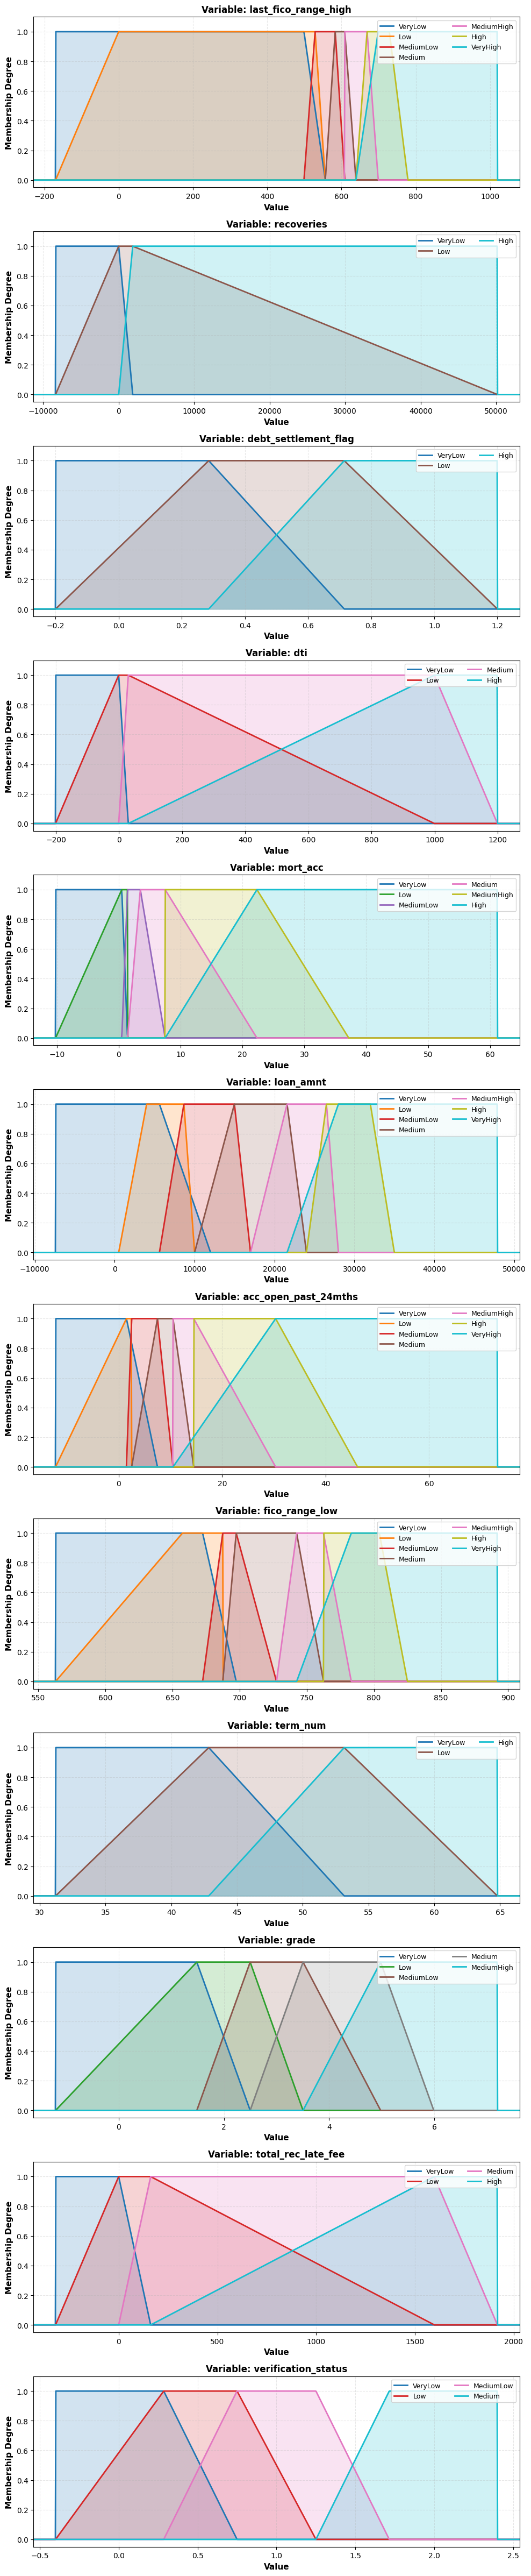

[INFO] Membership functions saved to: membership_functions_key.png


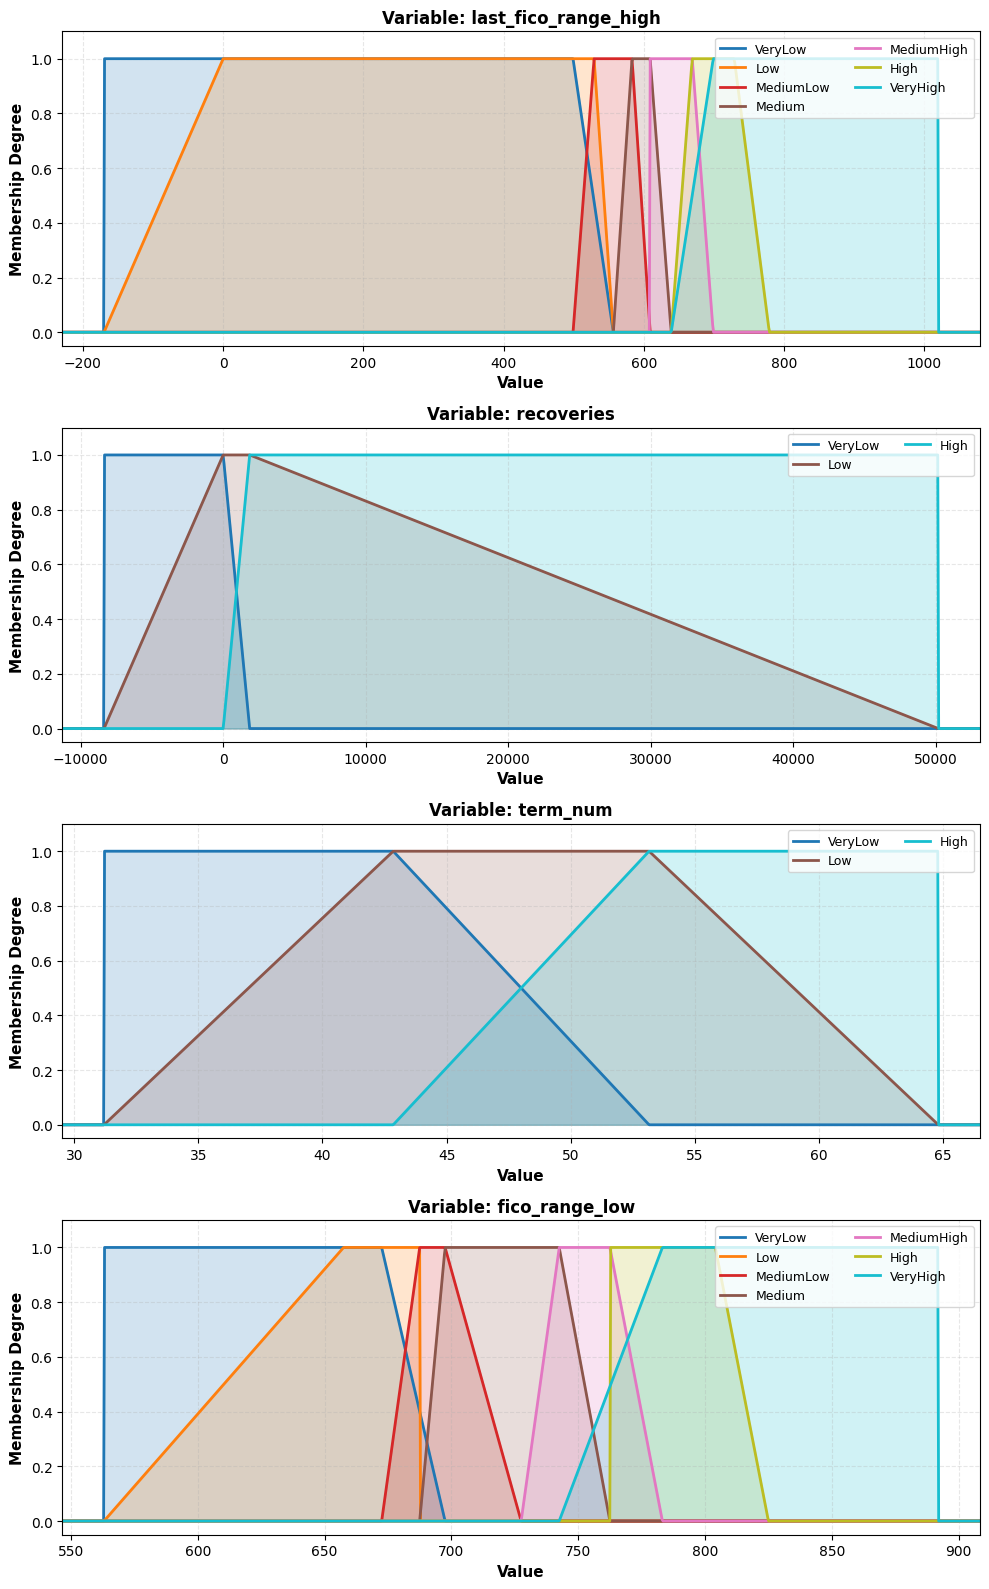

[INFO] Paper membership functions saved: membership_functions_paper.png
[INFO] Variables plotted: last_fico_range_high, recoveries, term_num, fico_range_low

[INFO] -------------------- Fuzzy Rule System Summary --------------------

[INFO] General Statistics:
  Total Rules:     717
  Total Trees:     25
  Class 0 Rules:   204 (28.5%)
  Class 1 Rules:   513 (71.5%)

[INFO] Variables:
  Total Variables: 12
  Variables: acc_open_past_24mths, debt_settlement_flag, dti, fico_range_low, grade, last_fico_range_high, loan_amnt, mort_acc, recoveries, term_num, total_rec_late_fee, verification_status

[INFO] Linguistic Terms:
  Total Terms:     60
  Avg per Variable: 5.0

[INFO] -------------------- Top 15 Rules (sorted by logit) --------------------

 Rank  Tree  Class  Logit  Antecedents                                                                                Rule
    1     1      1 +9.126            5 last_fico_range_high IS (VeryLow OR Low) AND recoveries IS (Low OR High) AND deb...
 

In [29]:
ef.plot_membership_functions(
    linguistic_terms,
    save_path='membership_functions_all.png'
)

ef.plot_membership_functions(
    linguistic_terms,
    variables_to_plot=['last_fico_range_high', 'recoveries', 'term_num', 'fico_range_low'],
    save_path='membership_functions_key.png'
)

ef.plot_membership_functions_paper(
    linguistic_terms,
    variables=['last_fico_range_high', 'recoveries', 'term_num', 'fico_range_low'],
    output_path='membership_functions_paper.png'
)

summary_df = ef.summarize_fuzzy_rules(
    fuzzy_rules,
    linguistic_terms,
    top_n=15,
    sort_by='logit'
)

ef.export_rules_for_paper(
    fuzzy_rules,
    linguistic_terms,
    output_file='fuzzy_rules_paper.txt',
    max_rules=20
)